In [1]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [2]:

# libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

# libraries for fairness
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer


from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)
     
    

    

In [3]:
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Equalized_odds_difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())


def metric_frame (feature):
    mf = MetricFrame({
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'TPR': true_positive_rate,
        'TNR': true_negative_rate, },
        y_test, test_preds, sensitive_features = feature)
    return mf.by_group


def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})

In [4]:

# define for the metric frame
metrics = {
    'accuracy': accuracy_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count,
    'balanced error rate': balanced_accuracy_score}

In [5]:
data = pd.read_csv('/Users/user/Downloads/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv')
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
# Display unique values in the 'race' column along with their counts
race_counts = data['race'].value_counts()

# Display the unique values and their counts
print(race_counts)

Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64


In [7]:

replaceDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25, 
'[30-40)' : 35, 
'[40-50)' : 45, 
'[50-60)' : 55,
'[60-70)' : 65, 
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

data['age'] = data['age'].apply(lambda x : replaceDict[x])
print(data['age'].head())

0     5
1    15
2    25
3    35
4    45
Name: age, dtype: int64


In [8]:
data.dropna(inplace = True)
print('Total data = ', len(data))
print('Unique entries = ', len(np.unique(data['patient_nbr'])))
data.drop_duplicates(['patient_nbr'], keep = 'first', inplace = True)
print('Length after removing Duplicates:', len(data))

Total data =  101766
Unique entries =  71518
Length after removing Duplicates: 71518


In [9]:

data['discharge_disposition_id'] = data['discharge_disposition_id'].apply(lambda x : 1 if int(x) in [6, 8, 9, 13] 
                                                                           else ( 2 if int(x) in [3, 4, 5, 14, 22, 23, 24]
                                                                           else ( 10 if int(x) in [12, 15, 16, 17]
                                                                           else ( 11 if int(x) in [19, 20, 21]
                                                                           else ( 18 if int(x) in [25, 26] 
                                                                           else int(x) )))))

data = data[~data.discharge_disposition_id.isin([11,13,14,19,20,21])]

data['admission_type_id'] = data['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) ))

data['admission_source_id'] = data['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [13, 14]
                                                            else int(x) ))))

for col in ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]:
    data[col] = data[col].apply(lambda x : 10 if x == 'Up' 
                                              else ( -10 if x == 'Down'                                                          
                                              else ( 0 if x == 'Steady'
                                              else  -20)))


data['change'] = data['change'].apply(lambda x : 1 if x == 'Ch'
                                                 else -1)


data['diabetesMed'] = data['diabetesMed'].apply(lambda x : -1 if x == 'No'
                                                else 1)


data['max_glu_serum'] = data['max_glu_serum'].apply(lambda x : 200 if x == '>200' 
                                                            else ( 300 if x == '>300'                                                          
                                                            else ( 100 if x == 'Norm'
                                                            else  0)))

data['A1Cresult'] = data['A1Cresult'].apply(lambda x : 7 if x == '>7' 
                                                         else (8 if  x == '>8'                                                        
                                                         else ( 5 if x == 'Norm'
                                                         else  0)))

In [10]:
diag_1 = Counter(list(data['diag_1'])).most_common(1)[0][0]
diag_2 = Counter(list(data['diag_2'])).most_common(1)[0][0]
diag_3 = Counter(list(data['diag_3'])).most_common(1)[0][0]
data['diag_1'] = data['diag_1'].apply(lambda x : diag_1 if x == '?' else x)
data['diag_2'] = data['diag_1'].apply(lambda x : diag_2 if x == '?' else x)
data['diag_3'] = data['diag_3'].apply(lambda x : diag_3 if x == '?' else x)

In [11]:
high_frequency = ['InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive', 
                 'Emergency/Trauma', 'Urology','ObstetricsandGynecology','Psychiatry','Pulmonology ','Nephrology','Radiologist']

low_frequency = ['Surgery-PlasticwithinHeadandNeck','Psychiatry-Addictive','Proctology','Dermatology','SportsMedicine','Speech','Perinatology',\
                'Neurophysiology','Resident','Pediatrics-Hematology-Oncology','Pediatrics-EmergencyMedicine','Dentistry','DCPTEAM','Psychiatry-Child/Adolescent',\
                'Pediatrics-Pulmonology','Surgery-Pediatric','AllergyandImmunology','Pediatrics-Neurology','Anesthesiology','Pathology','Cardiology-Pediatric',\
                'Endocrinology-Metabolism','PhysicianNotFound','Surgery-Colon&Rectal','OutreachServices',\
                'Surgery-Maxillofacial','Rheumatology','Anesthesiology-Pediatric','Obstetrics','Obsterics&Gynecology-GynecologicOnco']

pediatrics = ['Pediatrics','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology','Pediatrics-Hematology-Oncology',\
               'Pediatrics-Neurology','Pediatrics-Pulmonology', 'Anesthesiology-Pediatric', 'Cardiology-Pediatric', 'Surgery-Pediatric']

psychic = ['Psychiatry-Addictive', 'Psychology', 'Psychiatry',  'Psychiatry-Child/Adolescent', 'PhysicalMedicineandRehabilitation', 'Osteopath']


neurology = ['Neurology', 'Surgery-Neuro',  'Pediatrics-Neurology', 'Neurophysiology']


surgery = ['Surgeon', 'Surgery-Cardiovascular', \
          'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', \
             'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',  'Surgery-Thoracic',\
             'Surgery-Vascular', 'SurgicalSpecialty', 'Podiatry']
             
ungrouped = ['Endocrinology','Gastroenterology','Gynecology','Hematology','Hematology/Oncology','Hospitalist','InfectiousDiseases',\
           'Oncology','Ophthalmology','Otolaryngology','Pulmonology','Radiology']


missing = ['?']

In [12]:
data['diag_1'] = data['diag_1'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

In [13]:
data['diag_2'] = data['diag_2'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

In [14]:
data['diag_3'] = data['diag_3'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

In [15]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,5,?,5,18,1,1,...,-20,-20,-20,-20,-20,-20,-20,-1,-1,NO
1,149190,55629189,Caucasian,Female,15,?,1,1,7,3,...,-20,10,-20,-20,-20,-20,-20,1,1,>30
2,64410,86047875,AfricanAmerican,Female,25,?,1,1,7,2,...,-20,-20,-20,-20,-20,-20,-20,-1,1,NO
3,500364,82442376,Caucasian,Male,35,?,1,1,7,2,...,-20,10,-20,-20,-20,-20,-20,1,1,NO
4,16680,42519267,Caucasian,Male,45,?,1,1,7,1,...,-20,0,-20,-20,-20,-20,-20,1,1,NO


In [16]:
# Created another column and take it as 2 class problem, Label the <30 and >30 as YES and Other "N0" as No.

def check_label(text):
    if text == '>30' or text =='<30':
        return 'Yes'
    else:
        return 'No'
    
data['readmitted_2'] =data['readmitted'].apply(check_label) 

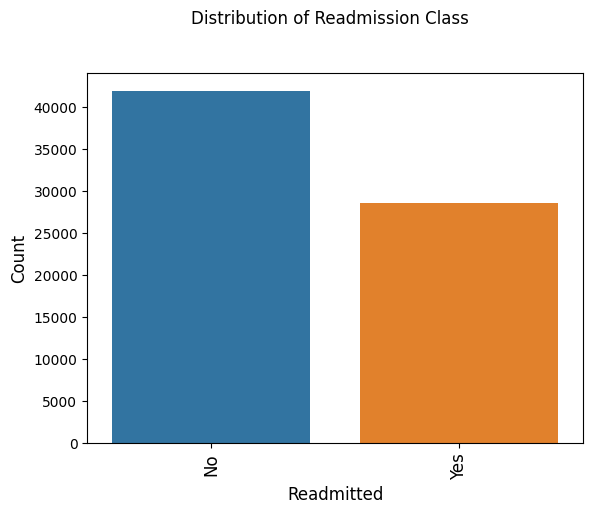

In [17]:
ax = sns.countplot(x='readmitted_2',   data= data)
plt.xlabel('Readmitted', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Readmission Class  \n\n', size = 12)
plt.show()

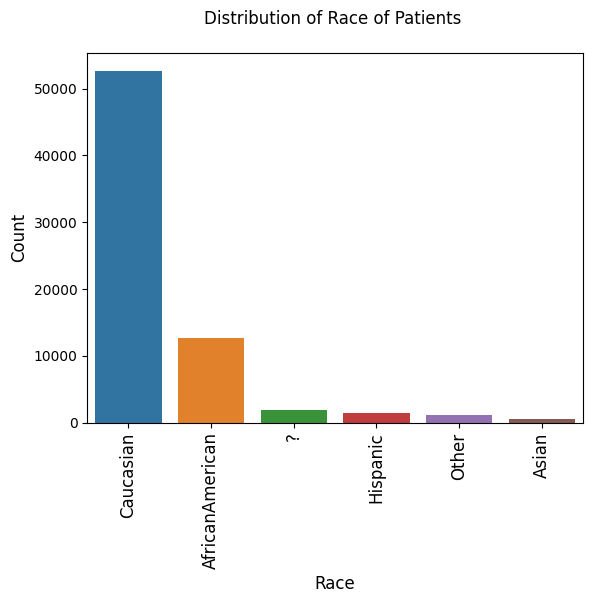

In [18]:
ax = sns.barplot(x=data['race'].value_counts().index,   y=data['race'].value_counts())
plt.xlabel('Race', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Race of Patients \n', size = 12)
plt.show()

In [19]:
data.loc[data['race'] == '?', 'race'] = 'Other'

In [20]:
# Drop the "Unknown/Invalid" gender of the data.
data.drop(data[data['gender'] == 'Unknown/Invalid'].index, inplace = True)

In [21]:
data.reset_index(inplace = True, drop = True)

In [22]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_2
0,2278392,8222157,Caucasian,Female,5,?,5,18,1,1,...,-20,-20,-20,-20,-20,-20,-1,-1,NO,No
1,149190,55629189,Caucasian,Female,15,?,1,1,7,3,...,10,-20,-20,-20,-20,-20,1,1,>30,Yes
2,64410,86047875,AfricanAmerican,Female,25,?,1,1,7,2,...,-20,-20,-20,-20,-20,-20,-1,1,NO,No
3,500364,82442376,Caucasian,Male,35,?,1,1,7,2,...,10,-20,-20,-20,-20,-20,1,1,NO,No
4,16680,42519267,Caucasian,Male,45,?,1,1,7,1,...,0,-20,-20,-20,-20,-20,1,1,NO,No


In [23]:
# Display unique values in the 'race' column along with their counts
race_counts = data['race'].value_counts()

# Display the unique values and their counts
print(race_counts)

Caucasian          52663
AfricanAmerican    12692
Other               3079
Hispanic            1506
Asian                491
Name: race, dtype: int64


In [24]:
data.drop(columns =['medical_specialty'], inplace = True)

In [25]:
data.drop(columns = ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone'], inplace = True)

In [26]:
# Make copy of data.
grouped_codes_df = data.copy()

In [27]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()

In [28]:
categorical_features =['race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed'] 

for i in categorical_features:
    grouped_codes_df[i] = le.fit_transform(grouped_codes_df[i])

In [29]:
label = le.fit(grouped_codes_df['readmitted_2'])

In [30]:
grouped_codes_df['readmitted_2_encoded'] = label.transform(grouped_codes_df['readmitted_2'])

In [31]:
grouped_codes_df = grouped_codes_df.drop(columns= ['encounter_id', 'patient_nbr', 'readmitted','readmitted_2','payer_code','weight'])

In [32]:
grouped_codes_df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted_2_encoded
0,2,0,0,3,4,0,1,41,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,2,3,59,0,18,...,0,0,0,0,0,3,0,1,1,1
2,0,0,2,0,0,2,2,11,5,13,...,0,0,0,0,0,0,0,0,1,0
3,2,1,3,0,0,2,2,44,1,16,...,0,0,0,0,0,3,0,1,1,0
4,2,1,4,0,0,2,1,51,0,8,...,0,0,0,0,0,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70426,2,0,7,0,0,2,9,50,2,33,...,3,0,0,0,0,2,0,1,1,1
70427,4,0,4,0,0,2,14,73,6,26,...,0,0,0,0,0,3,0,1,1,1
70428,4,0,6,0,0,2,2,46,6,17,...,0,0,0,0,0,2,0,0,1,1
70429,2,0,8,0,0,2,5,76,1,22,...,0,0,0,0,0,3,0,1,1,0


In [33]:
# Display unique values in the 'race' column along with their counts
race_counts = grouped_codes_df['race'].value_counts()

# Display the unique values and their counts
print(race_counts)

2    52663
0    12692
4     3079
3     1506
1      491
Name: race, dtype: int64


In [34]:
X = grouped_codes_df.drop(columns= ['readmitted_2_encoded'])
y = grouped_codes_df['readmitted_2_encoded']
A = grouped_codes_df['race']

In [35]:
# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, 
    y, 
    A, 
    test_size = 0.20, 
    random_state=42)

In [36]:
# Display unique values in the 'race' column along with their counts
race_counts_training = X_train['race'].value_counts()

# Display the unique values and their counts
print(race_counts_training)

2    42178
0    10110
4     2470
3     1200
1      386
Name: race, dtype: int64


In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, A_train.shape , A_test.shape

((56344, 34), (14087, 34), (56344,), (14087,), (56344,), (14087,))

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import roc_auc_score


In [39]:
from sklearn.ensemble import RandomForestClassifier
rf_bal_sub = RandomForestClassifier(n_estimators = 450, max_depth=9, random_state=43, class_weight='balanced_subsample')


In [40]:
rf_bal = RandomForestClassifier(n_estimators = 450, max_depth=9, random_state=43, class_weight='balanced')


In [41]:
# set up model:
classifiers = [rf_bal_sub,
              rf_bal]

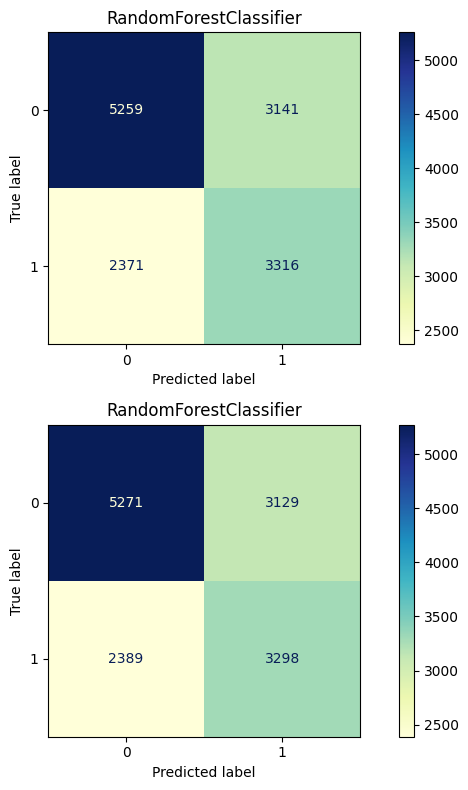

In [42]:
# test set
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

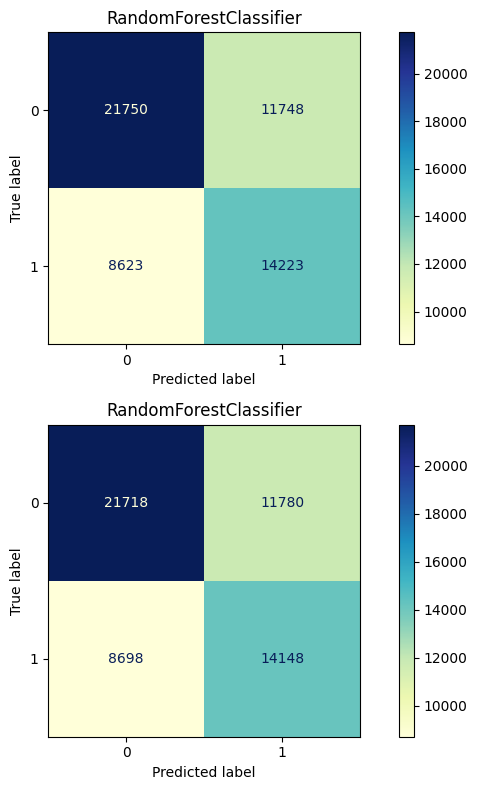

In [43]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

In [44]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f'{model}: {chr(10)} {classification_report(y_test, y_pred)}') 

RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       n_estimators=450, random_state=43): 
               precision    recall  f1-score   support

           0       0.69      0.63      0.66      8400
           1       0.51      0.58      0.55      5687

    accuracy                           0.61     14087
   macro avg       0.60      0.60      0.60     14087
weighted avg       0.62      0.61      0.61     14087

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=450,
                       random_state=43): 
               precision    recall  f1-score   support

           0       0.69      0.63      0.66      8400
           1       0.51      0.58      0.54      5687

    accuracy                           0.61     14087
   macro avg       0.60      0.60      0.60     14087
weighted avg       0.62      0.61      0.61     14087



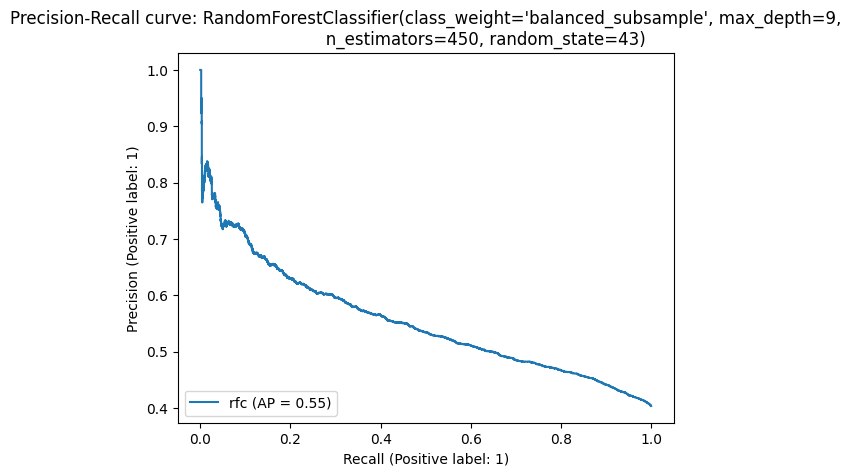

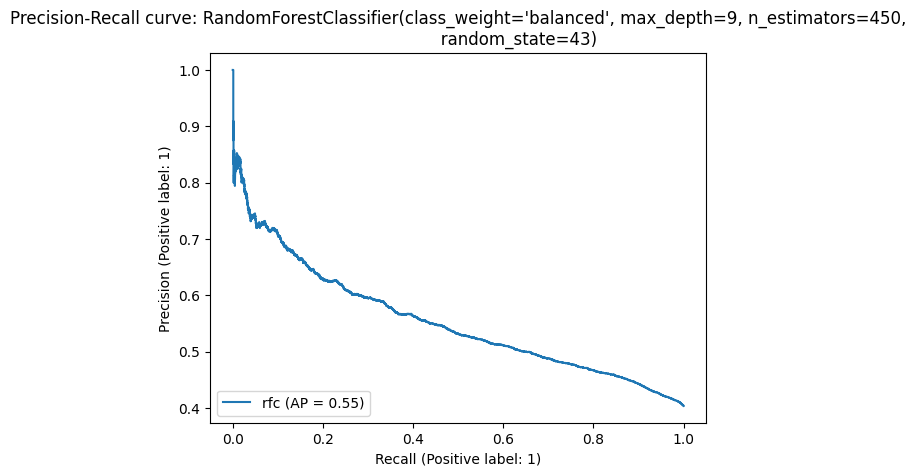

In [45]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')   

In [46]:
# define sensitive attributes
race =  A_test


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Race:{chr(10)}{model}: {chr(10)} {metric_frame (race)} {chr(10)}')

Race:
RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       n_estimators=450, random_state=43): 
            FPR       FNR       TPR       TNR
race                                        
0     0.724647  0.123047  0.876953  0.275353
1     0.740260  0.142857  0.857143  0.259740
2     0.823816  0.074689  0.925311  0.176184
3     0.645161  0.166667  0.833333  0.354839
4     0.564815  0.242938  0.757062  0.435185 

Race:
RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=450,
                       random_state=43): 
            FPR       FNR       TPR       TNR
race                                        
0     0.715661  0.123047  0.876953  0.284339
1     0.753247  0.142857  0.857143  0.246753
2     0.820888  0.075150  0.924850  0.179112
3     0.629032  0.175000  0.825000  0.370968
4     0.560185  0.254237  0.745763  0.439815 



In [47]:
# Define sensitive attributes
race = A_test

# Initialize lists to store the differences
difference_race1_and_2 = []
difference_race3_and_2 = []

# Metrics 
for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # scores on test set
    y_pred = model.predict_proba(X_test)[:, 1]

    # predictions (0 or 1) on test set
    test_preds = (y_pred >= np.mean(y_train)) * 1

    models_dict = {"Aware-Unmitigated": (test_preds, y_pred)}

    # Calculate the TPR for each race group
    tpr_race1 = metric_frame(race)["TPR"][1]  # TPR for race 1
    tpr_race2 = metric_frame(race)["TPR"][2]  # TPR for race 2
    tpr_race3 = metric_frame(race)["TPR"][3]  # TPR for race 5

    # Calculate and store the differences
    diff1_and_2 = tpr_race2 - tpr_race1
    diff3_and_2 = tpr_race2 - tpr_race3

    difference_race1_and_2.append(diff1_and_2)
    difference_race3_and_2.append(diff3_and_2)

    print(f'Race:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, race)} {chr(10)}') 

    # Calculate Equal Opportunity Differences for the current classifier
    eod_race1_and_2 = diff1_and_2
    eod_race3_and_2 = diff3_and_2

    print(f'Equal Opportunity Difference between Races Asian and Caucasian: {eod_race1_and_2}')
    print(f'Equal Opportunity Difference between Races Hispanic and Caucasian: {eod_race3_and_2}')

# Calculate the overall Equal Opportunity Differences between races 1 and 2 and between races 3 and 2
eod_race1_and_2_avg = sum(difference_race1_and_2) / len(difference_race1_and_2)
eod_race3_and_2_avg = sum(difference_race3_and_2) / len(difference_race3_and_2)

# Print the average Equal Opportunity Differences
print(f'Average Equal Opportunity Difference between Races Asian and Caucasian: {eod_race1_and_2_avg}')
print(f'Average Equal Opportunity Difference between Races Hispanic and Caucasian: {eod_race3_and_2_avg}')



Race:
RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       n_estimators=450, random_state=43): 
                                Aware-Unmitigated
Equalized_odds_difference               0.259002
False negative rate difference          0.168249
Balanced error rate difference          0.045376
Demographic parity difference           0.245119
  ------                                        
Overall AUC                             0.649504
AUC difference                          0.079955 

Equal Opportunity Difference between Races Asian and Caucasian: 0.06816834617664502
Equal Opportunity Difference between Races Hispanic and Caucasian: 0.09197786998616875
Race:
RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=450,
                       random_state=43): 
                                Aware-Unmitigated
Equalized_odds_difference               0.260703
False negative rate difference          0.179087
Balanced error rate di

## Reweighting in Grouped ICD9 Codes 

In [48]:
import aif360

from aif360.datasets import StandardDataset
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric

from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover

# fairlearn libraries
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation

from fairlearn.reductions import (ExponentiatedGradient, 
                                  EqualizedOdds, 
                                  ErrorRateParity)

pip install 'aif360[LawSchoolGPA]'


In [49]:


# libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

# libraries for fairness
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer


from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)

In [50]:
ds_aif = aif360.datasets.StandardDataset (grouped_codes_df, 
                                         label_name="readmitted_2_encoded",
                                         favorable_classes = [1], 
                                         protected_attribute_names=['race'], 
                                         privileged_classes= [lambda x: x == 2],
                                         )

In [51]:
# test, train split
ds_train, ds_test = ds_aif.split([0.80], shuffle=True)

In [52]:
# pre-processing - reweighing 
# define priviledged & unpriviledged groups
unpriv = [{'race': 3}, {'race': 1}]
priv = [{'race': 2}]

# for age change gender lavel to age 

# reweigh
RW = Reweighing (unprivileged_groups = unpriv, 
                 privileged_groups = priv)

RW_train = RW.fit_transform(ds_train)

In [53]:
# check for metric before and after transforming 
# OG ds
metric_train = BinaryLabelDatasetMetric(ds_train,
                                        unprivileged_groups = unpriv,
                                        privileged_groups = priv)

explainer_train = MetricTextExplainer(metric_train)

# transpormed ds
metric_transf_train = BinaryLabelDatasetMetric(RW_train,
                                               unprivileged_groups=unpriv,
                                               privileged_groups=priv)

explainer_transf_train = MetricTextExplainer(metric_transf_train)

In [54]:
# refit rfc model & get metrics
X_train = RW_train.features
y_train = RW_train.labels.ravel()
w_train = RW_train.instance_weights

X_test = ds_test.features
y_test = ds_test.labels.ravel()

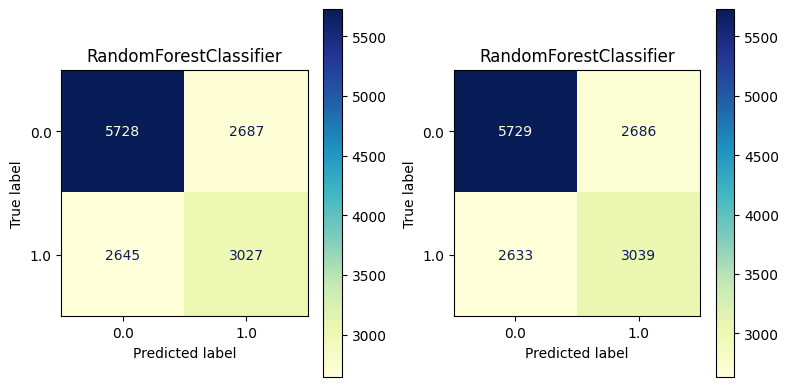

In [55]:
# test models with reweighted data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)

plt.tight_layout()
plt.show()

In [56]:
for cls in classifiers:
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = w_train)
  y_pred = cls.predict(X_test)
  
  print(f'{cls}: {chr(10)} {classification_report(y_test, y_pred)}')

RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       n_estimators=450, random_state=43): 
               precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      8415
         1.0       0.53      0.53      0.53      5672

    accuracy                           0.62     14087
   macro avg       0.61      0.61      0.61     14087
weighted avg       0.62      0.62      0.62     14087

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=450,
                       random_state=43): 
               precision    recall  f1-score   support

         0.0       0.69      0.68      0.68      8415
         1.0       0.53      0.54      0.53      5672

    accuracy                           0.62     14087
   macro avg       0.61      0.61      0.61     14087
weighted avg       0.62      0.62      0.62     14087



In [57]:
# define test 
ds_test_pred = ds_test.copy(deepcopy=True)

In [58]:
for cls in classifiers:
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight=dataset.instance_weights)
    y_pred = cls.predict(X_test)

    # scores on test set
    ds_test_pred.scores = cls.predict_proba(X_test)[:, 1]

    # predictions (0 or 1) on test set
    y_train_pred = cls.predict(X_train)
    test_preds = (y_pred >= np.mean(y_train)) * 1

    models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

    print(f'Race:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, race)} {chr(10)}')  # change age<> gender
    print(f'Race:{chr(10)}{cls}: {chr(10)} {metric_frame(race)} {chr(10)}')  # change age<> gender

    mf1 = MetricFrame(metrics=metrics,
                      y_true=y_test,
                      y_pred=y_pred,
                      sensitive_features=race)

    # The disaggregated metrics are stored in a pandas Series mf1.by_group:
    print(f"{cls}:\n {mf1.by_group}\n")
    print(f"{cls} difference:\n {mf1.difference(method='between_groups')}\n")

    # Calculate Equal Opportunity Differences
    tpr_race1 = metric_frame(race)["TPR"][1]  # TPR for race 1
    tpr_race2 = metric_frame(race)["TPR"][2]  # TPR for race 2
    tpr_race3 = metric_frame(race)["TPR"][3]  # TPR for race 3

    eod_race1_and_2 = tpr_race2 - tpr_race1
    eod_race3_and_2 = tpr_race2 - tpr_race3

    print(f"Equal Opportunity Difference between Races 1 and 2: {eod_race1_and_2}")
    print(f"Equal Opportunity Difference between Races 3 and 2: {eod_race3_and_2}")

Race:
RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       n_estimators=450, random_state=43): 
                                mitigated_pre-processing
Equalized_odds_difference                      0.097097
False negative rate difference                 0.096384
Balanced error rate difference                 0.039997
Demographic parity difference                  0.072906
  ------                                               
Overall AUC                                    0.607182
AUC difference                                 0.039997 

Race:
RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       n_estimators=450, random_state=43): 
            FPR       FNR       TPR       TNR
race                                        
0     0.332054  0.482826  0.517174  0.667946
1     0.240741  0.529412  0.470588  0.759259
2     0.315849  0.461303  0.538697  0.684151
3     0.314433  0.535714  0.464286  0.685567
4   

## UNAWARE Grouped Codes Model

In [59]:

# set test & train data & defining age as sensitive attribute - UNAWARE

X = grouped_codes_df.drop(columns=['race','readmitted_2_encoded'])
y = grouped_codes_df['readmitted_2_encoded']

A = grouped_codes_df['race']


# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, 
    y, 
    A, 

    test_size = 0.20, 
    random_state=42)


from sklearn.metrics import accuracy_score, confusion_matrix

def demographic_parity(y_true, y_pred):
    return abs(sum(y_pred == 1) / len(y_pred) - sum(y_true == 1) / len(y_true))

def equal_opportunity(y_true, y_pred):
    tpr_pred = sum((y_true == 1) & (y_pred == 1)) / sum(y_true == 1)
    tpr_true = sum((y_true == 1) & (y_pred == 1)) / sum(y_true == 1)
    return abs(tpr_pred - tpr_true)

def statistical_parity(y_true, y_pred):
    return abs(sum(y_pred == 1) / len(y_pred) - sum(y_true == 1) / len(y_true))

for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate fairness metrics
    dp = demographic_parity(y_test, y_pred)
    eo = equal_opportunity(y_test, y_pred)
    sp = statistical_parity(y_test, y_pred)
    
    print(f"Fairness Metrics for {type(model).__name__}:")
    print(f"Demographic Parity: {dp:.4f}")
    print(f"Equal Opportunity: {eo:.4f}")
    print(f"Statistical Parity: {sp:.4f}")
    print()

Fairness Metrics for RandomForestClassifier:
Demographic Parity: 0.0536
Equal Opportunity: 0.0000
Statistical Parity: 0.0536

Fairness Metrics for RandomForestClassifier:
Demographic Parity: 0.0545
Equal Opportunity: 0.0000
Statistical Parity: 0.0545



In [60]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score



classifier_names = ["RF Balanced Subsample Weight", "RF Balanced Weight"]

# Define the number of splits for cross-validation
n_splits = 4

# Loop over classifiers
for model, classifier_name in zip(classifiers, classifier_names):
    print(f"Evaluating {classifier_name}:")
    
    # Initialize lists to store classification reports and AUC scores
    classification_reports = []
    auc_scores = []
    
    # Perform cross-validation
    for train_index, test_index in StratifiedKFold(n_splits=n_splits).split(X_test, y_test):
        X_train_cv, X_test_cv = X_test.iloc[train_index], X_test.iloc[test_index]
        y_train_cv, y_test_cv = y_test.iloc[train_index], y_test.iloc[test_index]

        # Fit the model on the training data
        model.fit(X_train_cv, y_train_cv)

        # Make predictions on the test data
        y_pred_cv = model.predict(X_test_cv)

        # Predict probabilities for the 'Readmitted' class
        y_probs_cv = model.predict_proba(X_test_cv)[:, 1]

        # Compute the ROC-AUC score
        auc_cv = roc_auc_score(y_test_cv, y_probs_cv)
        auc_scores.append(auc_cv)

        # Generate and store the classification report
        report_cv = classification_report(y_test_cv, y_pred_cv, target_names=['Not Readmitted', 'Readmitted'], output_dict=True)
        classification_reports.append(report_cv)

    # Calculate the average AUC score across cross-validation folds
    avg_auc_score = sum(auc_scores) / len(auc_scores)
    
    # Calculate the average classification report across cross-validation folds
    avg_classification_report = {}
    for label in ['Not Readmitted', 'Readmitted']:
        avg_classification_report[label] = {
            'precision': sum(report[label]['precision'] for report in classification_reports) / len(classification_reports),
            'recall': sum(report[label]['recall'] for report in classification_reports) / len(classification_reports),
            'f1-score': sum(report[label]['f1-score'] for report in classification_reports) / len(classification_reports),
            'support': int(sum(report[label]['support'] for report in classification_reports) / len(classification_reports))
        }

    # Format and print the results
    print("Average Classification Report Unaware of Race:")
    for label in avg_classification_report:
        print(f"{label}:")
        for metric in avg_classification_report[label]:
            print(f"{metric}: {avg_classification_report[label][metric]:.2f}")
        print()
    print(f"Average AUC Score: {avg_auc_score:.2f}")
    print("\n")

Evaluating RF Balanced Subsample Weight:
Average Classification Report Unaware of Race:
Not Readmitted:
precision: 0.68
recall: 0.66
f1-score: 0.67
support: 2100.00

Readmitted:
precision: 0.52
recall: 0.54
f1-score: 0.53
support: 1421.00

Average AUC Score: 0.64


Evaluating RF Balanced Weight:
Average Classification Report Unaware of Race:
Not Readmitted:
precision: 0.68
recall: 0.66
f1-score: 0.67
support: 2100.00

Readmitted:
precision: 0.52
recall: 0.54
f1-score: 0.53
support: 1421.00

Average AUC Score: 0.64




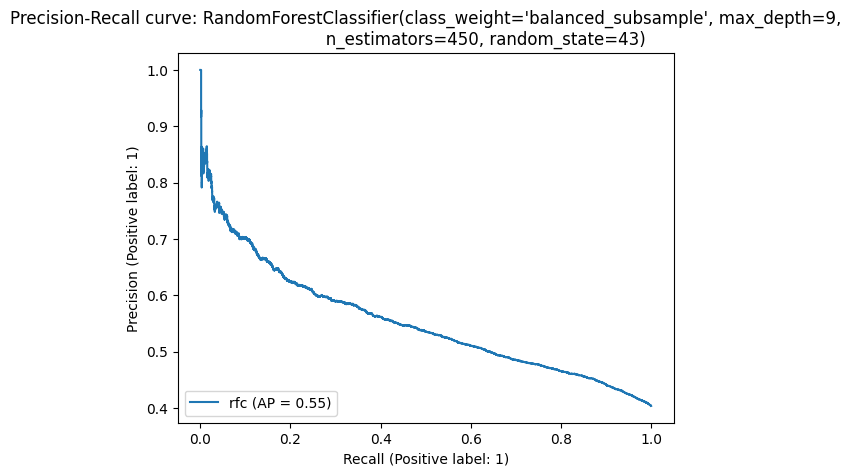

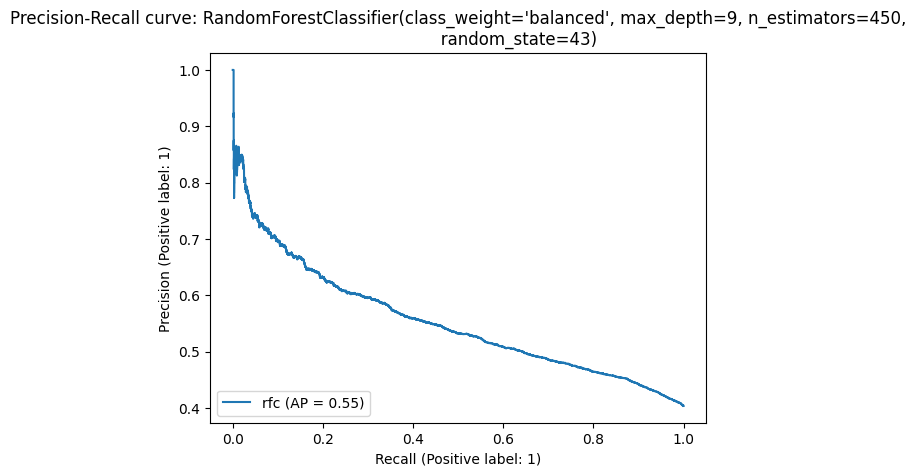

In [61]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')  

In [62]:
# define sensitive attributes
race =  A_test


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Race-Model is Unaware:{chr(10)}{model}: {chr(10)} {metric_frame (race)} {chr(10)}')

Race-Model is Unaware:
RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       n_estimators=450, random_state=43): 
            FPR       FNR       TPR       TNR
race                                        
0     0.714377  0.132812  0.867188  0.285623
1     0.753247  0.142857  0.857143  0.246753
2     0.813568  0.080682  0.919318  0.186432
3     0.698925  0.125000  0.875000  0.301075
4     0.645833  0.163842  0.836158  0.354167 

Race-Model is Unaware:
RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=450,
                       random_state=43): 
            FPR       FNR       TPR       TNR
race                                        
0     0.706033  0.135742  0.864258  0.293967
1     0.740260  0.142857  0.857143  0.259740
2     0.811290  0.081374  0.918626  0.188710
3     0.693548  0.125000  0.875000  0.306452
4     0.645833  0.175141  0.824859  0.354167 



In [63]:
# Define sensitive attributes
race = A_test

# Initialize lists to store the differences
difference_race1_and_2 = []
difference_race3_and_2 = []

# Metrics 
for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # scores on test set
    y_pred = model.predict_proba(X_test)[:, 1]

    # predictions (0 or 1) on test set
    test_preds = (y_pred >= np.mean(y_train)) * 1

    models_dict = {"Unaware": (test_preds, y_pred)}

    # Calculate the TPR for each race group
    tpr_race1 = metric_frame(race)["TPR"][1]  # TPR for race 1
    tpr_race2 = metric_frame(race)["TPR"][2]  # TPR for race 2
    tpr_race3 = metric_frame(race)["TPR"][3]  # TPR for race 5

    # Calculate and store the differences
    diff1_and_2 = tpr_race2 - tpr_race1
    diff3_and_2 = tpr_race2 - tpr_race3

    difference_race1_and_2.append(diff1_and_2)
    difference_race3_and_2.append(diff3_and_2)

    print(f'Race:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, race)} {chr(10)}') 

    # Calculate Equal Opportunity Differences for the current classifier
    eod_race1_and_2 = diff1_and_2
    eod_race3_and_2 = diff3_and_2

    print(f'Equal Opportunity Difference between Races 1 and 2: {eod_race1_and_2}')
    print(f'Equal Opportunity Difference between Races 3 and 2: {eod_race3_and_2}')


Race:
RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       n_estimators=450, random_state=43): 
                                  Unaware
Equalized_odds_difference       0.167734
False negative rate difference  0.083159
Balanced error rate difference  0.043214
Demographic parity difference   0.156171
  ------                                
Overall AUC                     0.648795
AUC difference                  0.078646 

Equal Opportunity Difference between Races 1 and 2: 0.06217480076401238
Equal Opportunity Difference between Races 3 and 2: 0.04431765790686948
Race:
RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=450,
                       random_state=43): 
                                  Unaware
Equalized_odds_difference       0.165457
False negative rate difference  0.093767
Balanced error rate difference  0.037058
Demographic parity difference   0.157833
  ------                                
Overall AUC   